In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from scipy import stats
from Bio import SeqIO

import collections
from collections import OrderedDict
from collections import Counter

from skbio.diversity import alpha_diversity
from skbio.diversity import beta_diversity
from io import StringIO
from skbio import TreeNode

from skbio.stats.distance import mantel
from skbio.stats.distance import anosim
from skbio.stats.distance import permanova
from skbio.stats.ordination import pcoa

In [2]:
dfuc95 = pd.read_csv('Data/result_uc95_list', header=None, sep="|", usecols=[0,2], index_col=1, names=["clst", "accid"])
dfuc95['clst']=dfuc95['clst'].map(lambda x: 'OTU'+str(x))
print(len(dfuc95))

1198


In [3]:
Italic =   ['$\it{In}$ $\it{situ}$ total RNA 1', '$\it{In}$ $\it{situ}$ total RNA 2', '$\it{In}$ $\it{situ}$ total RNA 3', '$\it{In}$ $\it{situ}$ total RNA 4', '$\it{In}$ $\it{situ}$ total RNA 5',
       '$\it{In}$ $\it{situ}$ total RNA 6', 'Onboard total RNA 1', 'Onboard total RNA 2', 'Onboard total RNA 3',
       'Onboard total RNA 4', 'Onboard total RNA 5', 'Onboard total RNA 6', 'Onboard total RNA 7']

dfcount = pd.read_csv('Data/count', header=0, index_col=0, sep='\t')
dfcount.head()

dfcount_clst=pd.concat([dfuc95, dfcount], axis=1, sort=False)

otutable=dfcount_clst.groupby('clst').sum()
otutable=otutable.astype(int)
otutable.columns=Italic

#otutable.head()

In [4]:
data = [list(otutable[Italic[0]]), list(otutable[Italic[1]]), list(otutable[Italic[2]]), list(otutable[Italic[3]]), list(otutable[Italic[4]]),
           list(otutable[Italic[5]]), list(otutable[Italic[6]]), list(otutable[Italic[7]]), list(otutable[Italic[8]]), list(otutable[Italic[9]]),
           list(otutable[Italic[10]]), list(otutable[Italic[11]]), list(otutable[Italic[12]])]

# Rarefaction curve

In [5]:
samples = ['insitu_6_2','insitu_8_1','insitu_9_1','insitu_10_1','insitu_11_1','insitu_12_1',
           'onboard_1_2','onboard_2_2','onboard_7_1','onboard_8_1','onboard_9_1','onboard_10_1','onboard_11_1']

dfrarefaction = pd.DataFrame()

for i in range(len(samples)):
    # data - read level
    file = 'Data/' + samples[i] + '_chosen'
    df = pd.read_csv(file, header = 0, usecols=[1,2], sep="\t")
    df.set_index("subject_id", inplace=True)
    df['sample'] = 1

    # Add OTU number to each read
    dfjoined=df.join(dfuc95, how='left')

    # Sort OTU in ascending order
    clstcollection=collections.Counter(dfjoined['clst'])
    clstsorted = OrderedDict(sorted(clstcollection.items(), key=lambda x:x[1]))
    clstsortedlist=list(clstsorted.keys())
            
    # Rearrangement
    dfclstsorted=pd.DataFrame()
    for k in range(len(clstsortedlist)):
        tmp = dfjoined[dfjoined['clst']==clstsortedlist[k]]
        dfclstsorted=pd.concat([dfclstsorted, tmp], sort=False)

    x=list()
    y=list()

    inputlist=list(dfclstsorted.clst)

    for m in range(len(inputlist)):
        tmp=inputlist[:m+1] # start from 1 read

        x.append(len(tmp))
        y.append(len(set(tmp)))

    dfoutput=pd.DataFrame({'x':x, 'y':y})
    dfoutput['sample']=Italic[i]

    dfrarefaction=pd.concat([dfrarefaction, dfoutput], sort=False)

#dfrarefaction.tail()

# Alpha beta diversity

In [6]:
from scipy import stats

def MannWhitneyU(df):
    A=list(df[df['subject']=='insitu']['data'])
    B=list(df[df['subject']=='onboard']['data'])
    print(stats.mannwhitneyu(A, B, alternative='two-sided'))

In [7]:
obs_otus=pd.DataFrame()
shannon=pd.DataFrame()
faith_pd=pd.DataFrame()

subjects=['insitu','insitu','insitu','insitu','insitu','insitu','onboard','onboard','onboard','onboard','onboard','onboard','onboard']

# observed OTUs
obs_otus['data']=alpha_diversity('observed_otus', data, Italic)
obs_otus['subject']=subjects
obs_otus['metrics'] = 'Observed OTUs'
MannWhitneyU(obs_otus)

# shannon
shannon['data']=alpha_diversity('shannon', data, Italic)
shannon['subject']=subjects
shannon['metrics'] = 'Shannon diversity'
MannWhitneyU(shannon)

# Faith’s PD
otu_ids=list(otutable.index)

with open('/nfs_share/motoki/metatra/fasttree/fasttree_GTRCAT_mafft') as f:
    s = f.read()
tree = TreeNode.read(StringIO(s)).root_at_midpoint()

faith_pd['data']=alpha_diversity('faith_pd', data, ids=Italic, otu_ids=otu_ids, tree=tree)
faith_pd['subject']=subjects
faith_pd['metrics'] = "Faith's PD"
MannWhitneyU(faith_pd)

MannwhitneyuResult(statistic=24.0, pvalue=0.7206168929939794)
MannwhitneyuResult(statistic=38.0, pvalue=0.01841616057630396)
MannwhitneyuResult(statistic=26.0, pvalue=0.5203168005073666)


In [8]:
obs_otus.replace('insitu', '$\it{in}$ $\it{situ}$', inplace=True)
shannon.replace('insitu', '$\it{in}$ $\it{situ}$', inplace=True)
faith_pd.replace('insitu', '$\it{in}$ $\it{situ}$', inplace=True)

# Beta diversity

In [9]:
sample_md = pd.DataFrame(index=Italic)
sample_md['ids']=Italic
sample_md['subject']=subjects
#sample_md

In [10]:
# weighted UniFrac distances
wu_dm = beta_diversity("weighted_unifrac", data, Italic, tree=tree,
                       otu_ids=otu_ids)

# PERMANOVA 
results = permanova(wu_dm, sample_md, column='subject', permutations=999)
print('PERMANOVA:', results['test statistic']) #0.7632275132275134
print(results['p-value'])
print(results['p-value'] < 0.1)

PERMANOVA: 17.23006662189272
0.002
True


/home/motoki/miniconda3/envs/skbio_py36/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -2.5779981636833815e-05 and the largest is 0.013035430027747137.
  RuntimeWarning


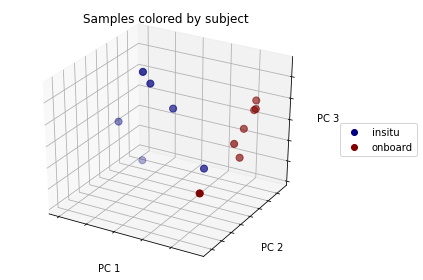

In [11]:
wu_pc = pcoa(wu_dm)
fig = wu_pc.plot(sample_md, 'subject',
                 axis_labels=('PC 1', 'PC 2', 'PC 3'),
                 title='Samples colored by subject', cmap='jet', s=50)

/home/motoki/miniconda3/envs/skbio_py36/lib/python3.6/site-packages/seaborn/categorical.py:2781: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
/home/motoki/miniconda3/envs/skbio_py36/lib/python3.6/site-packages/seaborn/categorical.py:2781: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
/home/motoki/miniconda3/envs/skbio_py36/lib/python3.6/site-packages/seaborn/categorical.py:2781: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


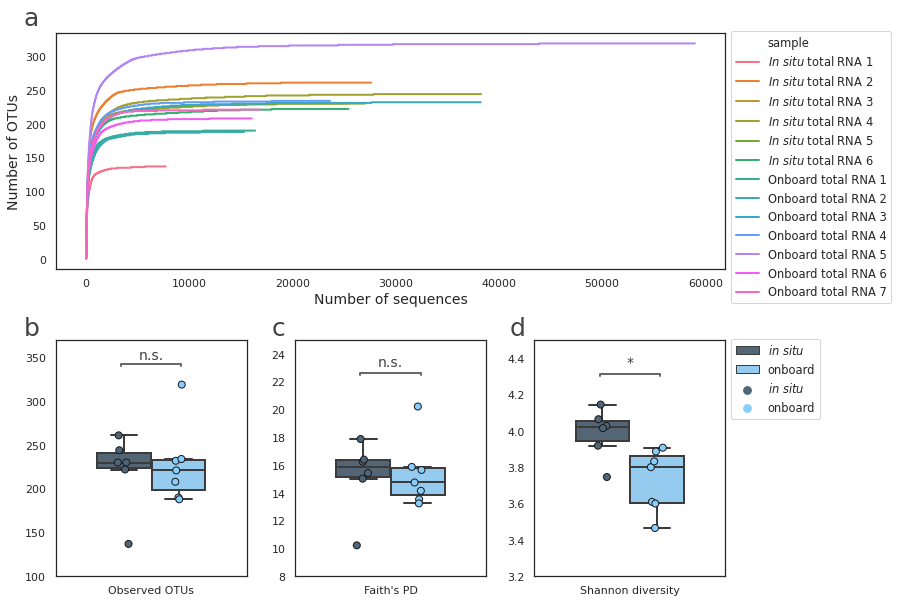

In [12]:
col = ['#4E667A', '#87ceff']

fig=plt.figure(figsize=(15, 10))

gs = gridspec.GridSpec(2,3)
gs.update(left=0.33, right=0.95)

sns.set(style="ticks", rc={"lines.linewidth": 2})
sns.set_style('white')


# Rarefaction curve
ax1 = plt.subplot(gs[0, :])

sns.lineplot(
    x="x", y="y", hue="sample", legend="full", data=dfrarefaction, ax=ax1
)
ax1.set_xlabel("Number of sequences", fontsize=14)
ax1.set_ylabel("Number of OTUs", fontsize=14)
ax1.legend(bbox_to_anchor=(1, 1.03),loc='upper left', fontsize=11.5, title=None)


# observed OTUs
ax2 = plt.subplot(gs[1, 0])

sns.boxplot(
    x='metrics', y='data', hue='subject', data=obs_otus, 
    palette=col, fliersize=0, ax=ax2
)
sns.stripplot(
    x='metrics', y='data', hue='subject', data=obs_otus,
    jitter=True, split=True, linewidth=1, palette=col, size=7, edgecolor='k',ax=ax2
)
ax2.set_ylim(100,370)

stats = ['n.s.']
for i in range(len(stats)):
    x1, x2 = [-0.22, 0.22]
    y=340
    ax2.plot([x1, x1, x2, x2], [y, y+2, y+2, y], lw=2, c='#686868')
    ax2.text((x1+x2)*.5, y+5, stats[i], ha='center', va='bottom', color='#424242', fontsize=14)    
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.get_legend().remove()


# faith_pd
ax3 = plt.subplot(gs[1, 1])

sns.boxplot(
    x='metrics', y='data', hue='subject', data=faith_pd, 
    palette=col, fliersize=0, ax=ax3
)
sns.stripplot(
    x='metrics', y='data', hue='subject', data=faith_pd,
    jitter=True, split=True, linewidth=1, palette=col, size=7, edgecolor='k', ax=ax3
)
ax3.set_ylim(8,25)

stats = ['n.s.']
for i in range(len(stats)):
    x1, x2 = [-0.22, 0.22]
    y=22.5
    ax3.plot([x1, x1, x2, x2], [y, y+0.1, y+0.1, y], lw=2, c='#686868')
    ax3.text((x1+x2)*.5, y+0.4, stats[i], ha='center', va='bottom', color='#424242', fontsize=14)    
ax3.set_xlabel('')
ax3.set_ylabel('')
ax3.get_legend().remove()


# shannon
ax4 = plt.subplot(gs[1, 2])

sns.boxplot(
    x='metrics', y='data', hue='subject', data=shannon, 
    palette=col, fliersize=0,ax=ax4
)
sns.stripplot(
    x='metrics', y='data', hue='subject', data=shannon,
    jitter=True, split=True, linewidth=1, palette=col, size=7, edgecolor='k', ax=ax4
)
ax4.set_ylim(3.2,4.5)

stats = ['*']
for i in range(len(stats)):
    x1, x2 = [-0.22, 0.22]
    y=4.3
    ax4.plot([x1, x1, x2, x2], [y, y+0.01, y+0.01, y], lw=2, c='#686868')
    ax4.text((x1+x2)*.5, y+0.04, stats[i], ha='center', va='bottom', color='#424242', fontsize=14)    
ax4.set_xlabel('')
ax4.set_ylabel('')


# legend
ax4.legend(bbox_to_anchor=(1, 1.03),loc='upper left', fontsize=11.5)

plt.subplots_adjust(wspace=0.25)
plt.subplots_adjust(hspace=0.3)

stats = ['a', 'b', 'c', 'd']
x = [0.3, 0.3, 0.53, 0.75]
y = [0.89, 0.46, 0.46, 0.46]
for i in range(len(stats)):
    fig.text(x[i], y[i], stats[i], color='#424242', fontsize=25)    
    
plt.show()
fig.savefig('Figures/FigS3.pdf', bbox_inches='tight')